<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_gage_ew_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# !pip install dataretrieval
import glob
import os
from dataretrieval import nwis as nwis
from dataretrieval import wqp
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import datetime
from tqdm import tqdm
from shapely import Point
from scipy.stats import linregress

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Pair gage ids with effective width point ids

In [37]:
gage_list = ['06801000','06801000','06801000',
             '06800500','06800500','06800500',
             '06805500','06805500','06805500',
             '06800000','06800000','06800000',
             '06775900','06775900','06775900',
             '06620000','06620000','06620000']

points = [201625, # 06801000
          153085,
          201888,
          246043, # 06800500
          246016,
          246048,
          202726, # 06805500
          203066,
          202446,
          120725, # 06800000
          120445,
          120748,
          94011, # 06775900
          93932,
          94005,
          41913, # 06620000
          41900,
          41930]


gage_pts = pd.DataFrame({'gage_id': gage_list,
                         'iindex': points})

u_gage_list = []
for g in set(gage_list):
    u_gage_list.append(g)

gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250909.shp'), how='outer', on='iindex')[['gage_id', 'iindex', 'riv_length']]
gage_pts

,gage_id,iindex,riv_length
0,NaN,11750,286.834439
1,NaN,27910,520.411858
2,NaN,30618,324.754737
3,NaN,35136,66.485390
4,NaN,38194,116.262817
5,NaN,38526,86.358781
6,NaN,41178,191.552417
7,06620000,41900,140.711919
8,06620000,41913,NaN
9,06620000,41930,NaN


Load gages for 27 gage validation

In [42]:
gage_pts = gpd.read_file('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_2.shp')[['iindex', 'site_no']]
gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250918.shp'), how='outer', on='iindex')[['site_no', 'iindex', 'riv_length']]
gage_list = gage_pts.site_no.tolist()
gage_pts

,site_no,iindex,riv_length
0,06797500,11750,286.834439
1,06799315,27910,520.411858
2,06759500,30618,324.754737
3,06721000,35136,66.485390
4,06711565,38194,116.262817
5,06710247,38526,86.358781
6,06714215,41178,191.552417
7,06620000,41900,140.711919
8,06652000,57498,419.438461
9,06785500,64575,285.088443


Load in-situ widths from USGS

In [18]:
width_dfs = []
for gage in set(gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    # ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['gage_width_m'] = isw.width_ft / 3.28
isw = isw[['date', 'gage_width_m', 'site_no']].set_index(['site_no', 'date'])
isw

KeyboardInterrupt: 

Discharge

In [43]:
# sites = ['06620000', '06775900', '06800000', '06800500', '06801000', '06805500']
sites = gage_list

# # first and last dates same as for in situ widths
# start = str(isw.index.sortlevel(1)[0][0][1])
# end = str(isw.index.sortlevel(1)[0][-1][1])

Q = nwis.get_record(sites, service='dv', start='2018-01-01', end='2024-12-31').reset_index()
Q['date'] = Q.datetime.dt.date
Q = Q[['site_no', 'date', '00060_Mean']]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
Q = Q.rename(columns={'00060_Mean': 'Q_cms'})
Q = Q.set_index(['site_no', 'date'])
Q

Q_cms
site_no  date                
06620000 2018-01-01  3.740696
         2018-01-02  3.457310
         2018-01-03  3.343955
         2018-01-04  3.400633
         2018-01-05  3.513987
...                       ...
06800000 2024-12-27  0.793481
         2024-12-28  0.816152
         2024-12-29  0.864327
         2024-12-30  0.872829
         2024-12-31  0.838823

[69020 rows x 1 columns]

Join in-situ width and discharge to build rating curves

In [ ]:
cotemporal_wQ = Q.join(isw, how='inner', on=['site_no', 'date'])
cotemporal_wQ = cotemporal_wQ.loc[cotemporal_wQ.gage_width_m != 0]
cotemporal_wQ['logw'] = np.log10(cotemporal_wQ.gage_width_m)
cotemporal_wQ['logQ'] = np.log10(cotemporal_wQ.Q_cms)
cotemporal_wQ

Q_cms  gage_width_m      logw      logQ
site_no  date                                                    
06620000 2011-08-22   11.392119     46.951220  1.671647  1.056605
         2011-10-12    6.206155     46.951220  1.671647  0.792823
         2012-01-30    3.825712     39.634146  1.598070  0.582712
         2012-03-30   17.173195     47.865854  1.680026  1.234851
         2012-06-22    4.279129     37.804878  1.577548  0.631355
...                         ...           ...       ...       ...
06805500 2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-08-12  253.347129    378.048780  2.577548  2.403716
         2025-08-27  121.856002    378.048780  2.577548  2.085847

[1219 rows x 4 columns]

Text(0.02, 0.5, 'Gage width (m)')

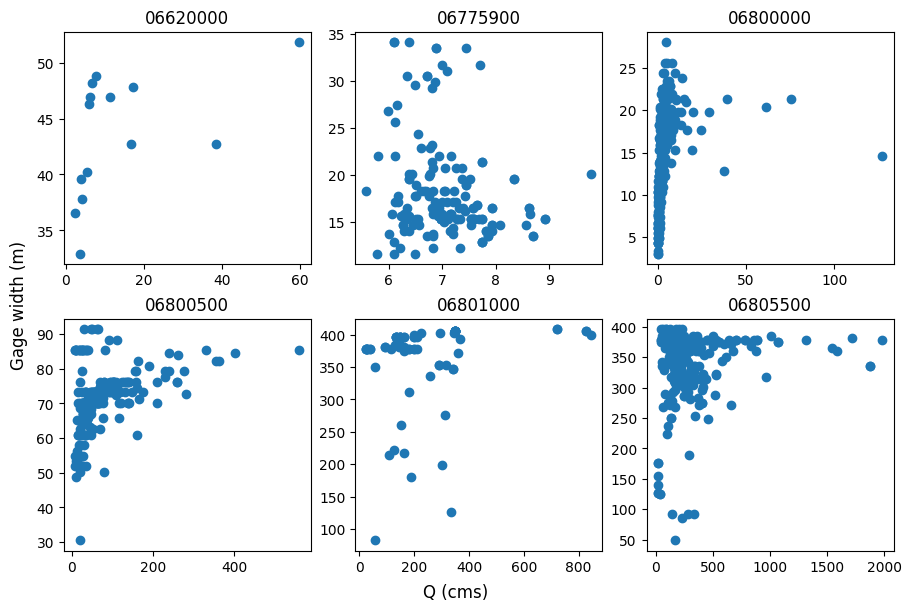

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.gage_width_m)
    ax.set_title(sn)
    p += 1

fig.supxlabel('Q (cms)')
fig.supylabel('Gage width (m)')

Build power law rating curves with cotemporal gage w and Q

Text(0.5, 0.98, 'Power law w/Q rating curves')

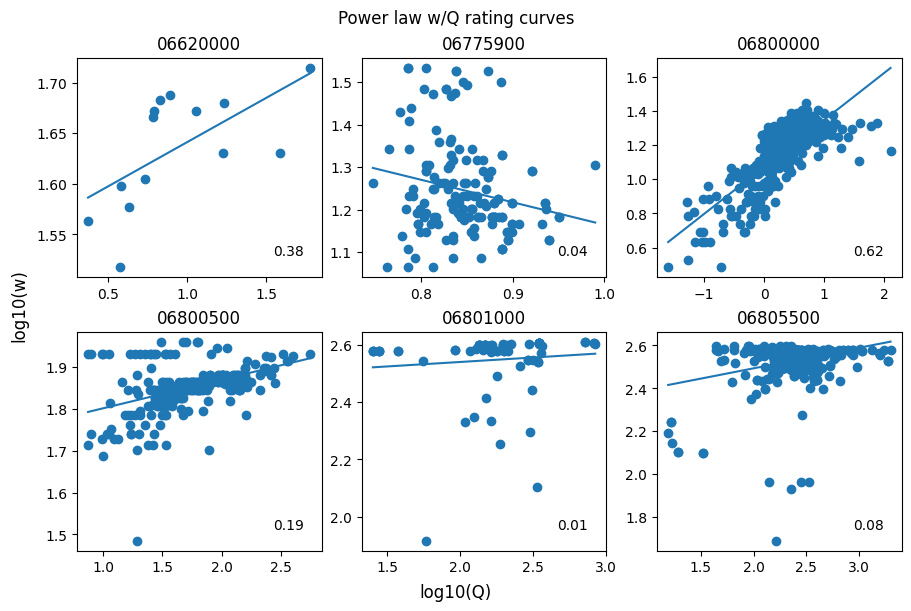

In [ ]:
rc_slopes = []
rc_intercepts = []
r2s = []


fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)
p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):

    slope, intercept, r, pval, _ = linregress(df.logQ, df.logw)

    rc_slopes.append(slope)
    rc_intercepts.append(intercept)
    r2s.append(r ** 2)

    ax = axs.flatten()[p]
    ax.scatter(df.logQ, df.logw)
    ax.set_title(sn)
    rc_x = np.linspace(min(df.logQ), max(df.logQ))

    ax.plot(rc_x, rc_x * slope + intercept)
    ax.text(0.8, 0.1, f'{round(r ** 2, 2)}', transform=ax.transAxes)
    p += 1

fig.supxlabel('log10(Q)')
fig.supylabel('log10(w)')
fig.suptitle('Power law w/Q rating curves')

In [ ]:
rating_curve_parms = pd.DataFrame({'site_no': u_gage_list, 'b': rc_slopes, 'loga': rc_intercepts, 'r2': r2s}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,b,loga,r2,a
site_no,,,,
06800000,0.087846,1.553382,0.383412,35.758761
06800500,-0.528364,1.692555,0.042450,49.266824
06775900,0.275466,1.072538,0.616820,11.817848
06620000,0.068638,1.732994,0.186642,54.074626
06805500,0.031141,2.477969,0.008993,300.585898
06801000,0.095966,2.301501,0.078646,200.216932


Estimate width from rating curve, full join with in-situ widths on date and gage id

In [ ]:
def est_width(row, site_no):
    a = rating_curve_parms.loc[site_no, 'a']
    b = rating_curve_parms.loc[site_no, 'b']
    Q = row['Q_cms']

    return a * (Q ** b)

Q['rc_width_m'] = Q.apply(lambda row: est_width(row, row.name[0]), axis=1)
Q = Q.join(isw, how='outer', on=['site_no', 'date'])
Q

Q_cms  rc_width_m  gage_width_m
site_no  date                                            
06620000 2007-11-19    3.967405   59.439310           NaN
         2007-11-20    3.740696   59.199738           NaN
         2007-11-21    3.485648   58.913488           NaN
         2007-11-22    3.230601   58.607024           NaN
         2007-11-23    2.862199   58.121987           NaN
...                         ...         ...           ...
06805500 2025-08-30  123.556318  349.229742           NaN
         2025-08-31  127.523723  349.573630           NaN
         2025-09-01  181.367072  353.429025           NaN
         2025-09-02  459.085402  363.799788           NaN
         2025-09-03  385.405029  361.823254           NaN

[39189 rows x 3 columns]

Text(0.5, 0.98, 'Rating curve validation')

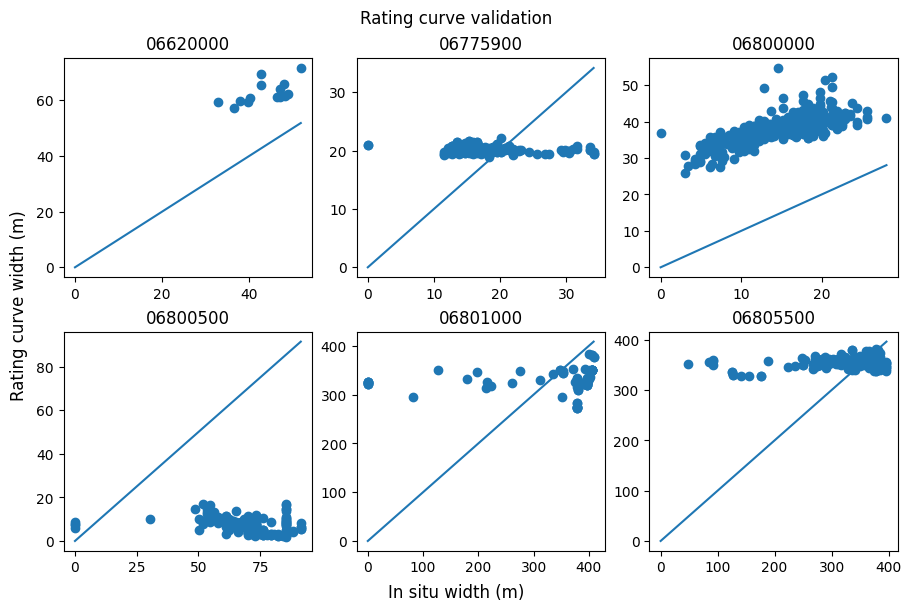

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in Q.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.rc_width_m)
    unity = np.linspace(0, (df.gage_width_m).max(skipna=True))
    ax.plot(unity, unity)
    ax.set_title(sn)
    p += 1

fig.supxlabel('In situ width (m)')
fig.supylabel('Rating curve width (m)')
fig.suptitle('Rating curve validation')

Load in effective width\
See stac_processing_download.ipynb

In [81]:
width_dfs = []
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    # width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/gage_effwidths_{year}_20250911_nond.csv'))
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{year}_g2_20250921.csv'))

allwidths = pd.concat(width_dfs)

allwidths['mgrs'] = allwidths.apply(lambda x: x['img_id'].split('_')[1], axis=1)
allwidths['date'] = allwidths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
allwidths['version'] = allwidths.apply(lambda x: x['img_id'].split('_')[3], axis=1)

allwidths = allwidths.loc[(allwidths.n_valid == allwidths.n_pixels) & (allwidths.n_valid > -999)]


nondup_widths = allwidths
allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,2063,S2B_14TMM_20240511_0_L2A,68202,2169,2169,444,3,0,2,151,24,14TMM,2024-05-11,0
2064,2064,S2B_13TGF_20240716_0_L2A,225467,162,162,84,0,0,0,43,12,13TGF,2024-07-16,0
2065,2065,S2A_14TPL_20241013_0_L2A,115317,4949,4949,1038,0,0,0,228,27,14TPL,2024-10-13,0
2066,2066,S2A_14TKL_20240728_0_L2A,225467,161,161,98,0,0,0,42,16,14TKL,2024-07-28,0


AWS S2 STAC holds duplicate versions of some images with different versions of the processing baseline. Identify tiles and dates with multiple images and select the one with the most up to date processing baseline.

In [ ]:
tile_dts = []
tile_dt_versions = []
for row in tqdm(allwidths.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))

tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version']).sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = (temp_df.head(1))
    nonduplicates.append(df_out)


nonduplicates = pd.concat(nonduplicates)
nonduplicates

13598it [00:00, 22137.28it/s]
100%|██████████| 2304/2304 [00:05<00:00, 393.94it/s]


,index,mgrs,date,version
0,178,14TPM,2023-04-07,0
0,321,15TTG,2019-08-28,1
0,1822,14TPM,2018-06-29,0
0,1939,14TQL,2024-10-25,0
0,684,14TQM,2021-12-30,1
...,...,...,...,...
0,361,14TLM,2021-07-09,0
0,2719,13TCF,2019-08-25,1
0,3044,14TPM,2022-04-14,0
0,1677,14TQL,2020-08-27,1


Join nonduplicate images with widths and gage ids

In [82]:
# nondup_widths = pd.merge(allwidths, nonduplicates[['mgrs', 'date', 'version']], 'right', on=['mgrs', 'date', 'version'])
nondup_widths = pd.merge(nondup_widths, gage_pts, how='left', on='iindex')
nondup_widths = nondup_widths.rename(columns={'gage_id': 'site_no'})
nondup_widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version,site_no,riv_length
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1,06764880,172.516752
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0,06800000,148.276448
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1,06635000,93.794831
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1,06630000,480.468419
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1,06797500,286.834439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12284,2063,S2B_14TMM_20240511_0_L2A,68202,2169,2169,444,3,0,2,151,24,14TMM,2024-05-11,0,06777495,573.022347
12285,2064,S2B_13TGF_20240716_0_L2A,225467,162,162,84,0,0,0,43,12,13TGF,2024-07-16,0,06764880,172.516752
12286,2065,S2A_14TPL_20241013_0_L2A,115317,4949,4949,1038,0,0,0,228,27,14TPL,2024-10-13,0,06793000,1341.859239
12287,2066,S2A_14TKL_20240728_0_L2A,225467,161,161,98,0,0,0,42,16,14TKL,2024-07-28,0,06764880,172.516752


In [33]:
nondup_widths.columns

Index(['Unnamed: 0', 'img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river',
       'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver', 'mgrs',
       'version', 'riv_length', 'sat_width_m', 'fraction_cloud',
       'fraction_snow', 'agency_cd', 'site_no', 'station_nm', 'site_tp_cd',
       'dec_lat_va', 'dec_long_v', 'coord_acy_', 'dec_coord_', 'alt_va',
       'alt_acy_va', 'alt_datum_', 'huc_cd', 'index_righ', 'geometry'],
      dtype='object')

Calculate effective width and fractions of cloud and snow

In [83]:
nondup_widths['sat_width_m'] = nondup_widths.n_river * 100 / nondup_widths.riv_length
nondup_widths['fraction_cloud'] = nondup_widths.n_cloud / nondup_widths.n_pixels
nondup_widths['fraction_snow'] = nondup_widths.n_snow / nondup_widths.n_pixels
nondup_widths = nondup_widths.set_index(['site_no', 'date'])
nondup_widths

,,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,version,riv_length,sat_width_m,fraction_cloud,fraction_snow
site_no,date,,,,,,,,,,,,,,,,,
06764880,2018-06-23,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,1,172.516752,39.996116,0.000000,0.0
06800000,2018-10-15,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,0,148.276448,18.209230,0.024390,0.0
06635000,2018-06-11,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,1,93.794831,13.860039,0.000000,0.0
06630000,2018-06-11,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,1,480.468419,31.635794,0.069388,0.0
06797500,2018-06-22,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,1,286.834439,25.101588,0.443548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06777495,2024-05-11,2063,S2B_14TMM_20240511_0_L2A,68202,2169,2169,444,3,0,2,151,24,14TMM,0,573.022347,77.483889,0.001383,0.0
06764880,2024-07-16,2064,S2B_13TGF_20240716_0_L2A,225467,162,162,84,0,0,0,43,12,13TGF,0,172.516752,48.690924,0.000000,0.0
06793000,2024-10-13,2065,S2A_14TPL_20241013_0_L2A,115317,4949,4949,1038,0,0,0,228,27,14TPL,0,1341.859239,77.355357,0.000000,0.0


Import likes and dislikes from river tinder

In [ ]:

def flatten(xss):
    return [x for xs in xss for x in xs]



checked_img_path = '/content/drive/MyDrive/effwidth_results/rt_likes_dislikes'
lols = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'likes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lols.append(lines)

lods = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'dislikes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lods.append(lines)


lols = flatten(lols)
lods = flatten(lods)

lds = pd.DataFrame({'name': lols + lods})
lds['iindex'] = lds.apply(lambda x: int(x['name'][25:]), axis=1)
lds['img_id'] = lds.apply(lambda x: str(x['name'][0:24]), axis=1)
lds['like'] = (np.concatenate([np.repeat(True, len(lols)), np.repeat(False, len(lods))], axis=0))

lds

100%|██████████| 28/28 [00:00<00:00, 212.21it/s]


,name,iindex,img_id,like
0,S2A_14TQL_20240930_0_L2A_201625,201625,S2A_14TQL_20240930_0_L2A,True
1,S2A_15TTF_20240930_0_L2A_153085,153085,S2A_15TTF_20240930_0_L2A,True
2,S2A_15TTF_20240930_0_L2A_202726,202726,S2A_15TTF_20240930_0_L2A,True
3,S2A_15TTF_20240930_0_L2A_203066,203066,S2A_15TTF_20240930_0_L2A,True
4,S2A_15TTF_20240930_0_L2A_202446,202446,S2A_15TTF_20240930_0_L2A,True
...,...,...,...,...
1691,S2A_14TQL_20240913_0_L2A_202726,202726,S2A_14TQL_20240913_0_L2A,False
1692,S2A_14TQL_20240913_0_L2A_203066,203066,S2A_14TQL_20240913_0_L2A,False
1693,S2A_14TQL_20240913_0_L2A_202446,202446,S2A_14TQL_20240913_0_L2A,False
1694,S2A_14TQL_20240913_0_L2A_201888,201888,S2A_14TQL_20240913_0_L2A,False


Join rating curve width, gage width, and sat width on date

In [84]:
alldata = Q.join(nondup_widths, how='outer').reset_index()
# alldata = pd.merge(alldata, lds, how='outer',  on=['img_id', 'iindex'])
alldata = alldata.set_index(['site_no', 'date'])
alldata

Q_cms  Unnamed: 0                    img_id    iindex  \
site_no  date                                                                   
06620000 2018-01-01  3.740696         NaN                       NaN       NaN   
         2018-01-02  3.457310       632.0  S2B_13TCF_20180102_1_L2A   41900.0   
         2018-01-03  3.343955         NaN                       NaN       NaN   
         2018-01-04  3.400633         NaN                       NaN       NaN   
         2018-01-05  3.513987         NaN                       NaN       NaN   
...                       ...         ...                       ...       ...   
06800000 2024-12-27  0.793481         NaN                       NaN       NaN   
         2024-12-28  0.816152         NaN                       NaN       NaN   
         2024-12-29  0.864327      1559.0  S2A_14TPM_20241229_0_L2A  120725.0   
         2024-12-30  0.872829         NaN                       NaN       NaN   
         2024-12-31  0.838823         NaN                       NaN       NaN   

                     n_pixels  n_valid  n_river  n_cloud  n_snow  \
site_no  date                                                      
06620000 2018-01-01       NaN      NaN      NaN      NaN     NaN   
         2018-01-02     163.0    163.0     51.0      0.0   163.0   
         2018-01-03       NaN      NaN      NaN      NaN     NaN   
         2018-01-04       NaN      NaN      NaN      NaN     NaN   
         2018-01-05       NaN      NaN      NaN      NaN     NaN   
...                       ...      ...      ...      ...     ...   
06800000 2024-12-27       NaN      NaN      NaN      NaN     NaN   
         2024-12-28       NaN      NaN      NaN      NaN     NaN   
         2024-12-29     164.0    164.0     28.0      0.0     0.0   
         2024-12-30       NaN      NaN      NaN      NaN     NaN   
         2024-12-31       NaN      NaN      NaN      NaN     NaN   

                     n_cloudriver  n_edge  n_edgeriver   mgrs version  \
site_no  date                                                           
06620000 2018-01-01           NaN     NaN          NaN    NaN     NaN   
         2018-01-02           0.0    44.0         13.0  13TCF       1   
         2018-01-03           NaN     NaN          NaN    NaN     NaN   
         2018-01-04           NaN     NaN          NaN    NaN     NaN   
         2018-01-05           NaN     NaN          NaN    NaN     NaN   
...                           ...     ...          ...    ...     ...   
06800000 2024-12-27           NaN     NaN          NaN    NaN     NaN   
         2024-12-28           NaN     NaN          NaN    NaN     NaN   
         2024-12-29           0.0    43.0          4.0  14TPM       0   
         2024-12-30           NaN     NaN          NaN    NaN     NaN   
         2024-12-31           NaN     NaN          NaN    NaN     NaN   

                     riv_length  sat_width_m  fraction_cloud  fraction_snow  
site_no  date                                                                
06620000 2018-01-01         NaN          NaN             NaN            NaN  
         2018-01-02  140.711919    36.244265             0.0            1.0  
         2018-01-03         NaN          NaN             NaN            NaN  
         2018-01-04         NaN          NaN             NaN            NaN  
         2018-01-05         NaN          NaN             NaN            NaN  
...                         ...          ...             ...            ...  
06800000 2024-12-27         NaN          NaN             NaN            NaN  
         2024-12-28         NaN          NaN             NaN            NaN  
         2024-12-29  148.276448    18.883646             0.0            0.0  
         2024-12-30         NaN          NaN             NaN            NaN  
         2024-12-31         NaN          NaN             NaN            NaN  

[71446 rows x 18 columns]

In [80]:
t = alldata.loc['06680500']
t.loc[t.sat_width_m < 0]

,Q_cms,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,version,riv_length,sat_width_m,fraction_cloud,fraction_snow
date,,,,,,,,,,,,,,,,,,
2018-01-07,NaN,1723.0,S2A_13TEG_20180107_0_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,0,283.09493,-352.885161,1.0,1.0
2018-01-22,NaN,719.0,S2B_13TEG_20180122_0_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,0,283.09493,-352.885161,1.0,1.0
2018-01-29,NaN,1350.0,S2B_13TEG_20180129_0_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,0,283.09493,-352.885161,1.0,1.0
2018-02-06,NaN,1504.0,S2A_13TEG_20180206_1_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,1,283.09493,-352.885161,1.0,1.0
2018-02-11,NaN,1609.0,S2B_13TEG_20180211_1_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,1,283.09493,-352.885161,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01,12.950743,1315.0,S2A_13TEG_20241201_0_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,0,283.09493,-352.885161,1.0,1.0
2024-12-03,12.865727,1473.0,S2B_13TEG_20241203_0_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,0,283.09493,-352.885161,1.0,1.0
2024-12-06,12.780711,1589.0,S2B_13TEG_20241206_0_L2A,88928.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13TEG,0,283.09493,-352.885161,1.0,1.0


In [49]:
# good_gage_avg_ew = alldata.loc[alldata.like == True].groupby(by=['site_no', 'date']).agg(mean_sat_width_m=('sat_width_m', 'mean'))
# good_gage_avg_ew = good_gage_avg_ew.join(Q)

gage_avg_ew = alldata.groupby(by=['site_no', 'date']).agg(mean_sat_width_m=('sat_width_m', 'mean'))
gage_avg_ew = gage_avg_ew.join(Q)

How do cotemporal satellite and in-situ widths compare?

Text(0.5, 0.98, 'In-situ vs. satellite width comparison')

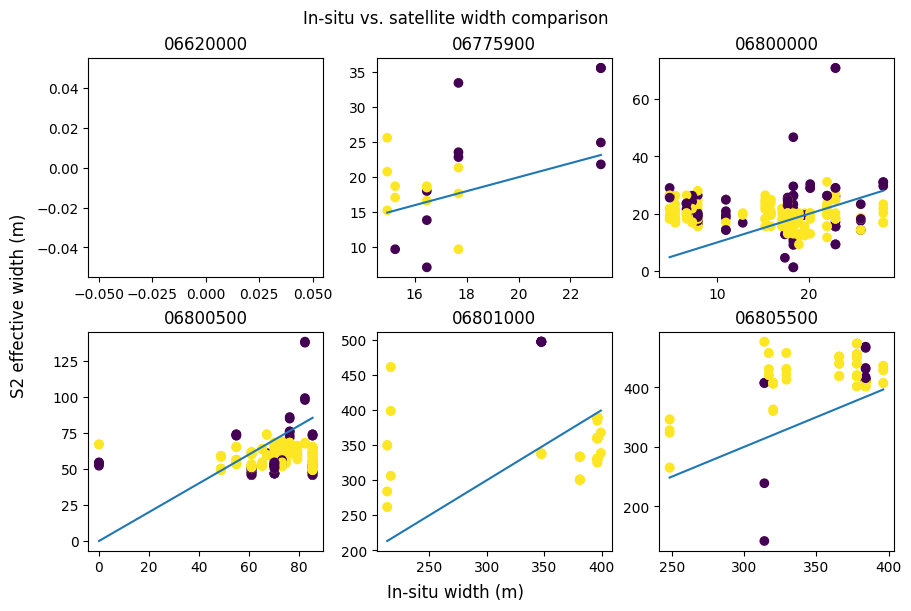

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
p = 0
for g, df in alldata.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.sat_width_m, c=df.like)
    unity = np.linspace(df.gage_width_m.min(), df.gage_width_m.max())
    ax.plot(unity, unity)
    ax.set_title(g)
    p += 1

fig.supxlabel('In-situ width (m)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('In-situ vs. satellite width comparison')

In [115]:
t.date

,date
0,2018-03-08
1,2018-03-13
2,2018-04-22
3,2018-04-27
4,2018-05-17
...,...
9772,2024-12-09
9773,2024-12-19
9774,2024-12-19
9775,2024-12-19


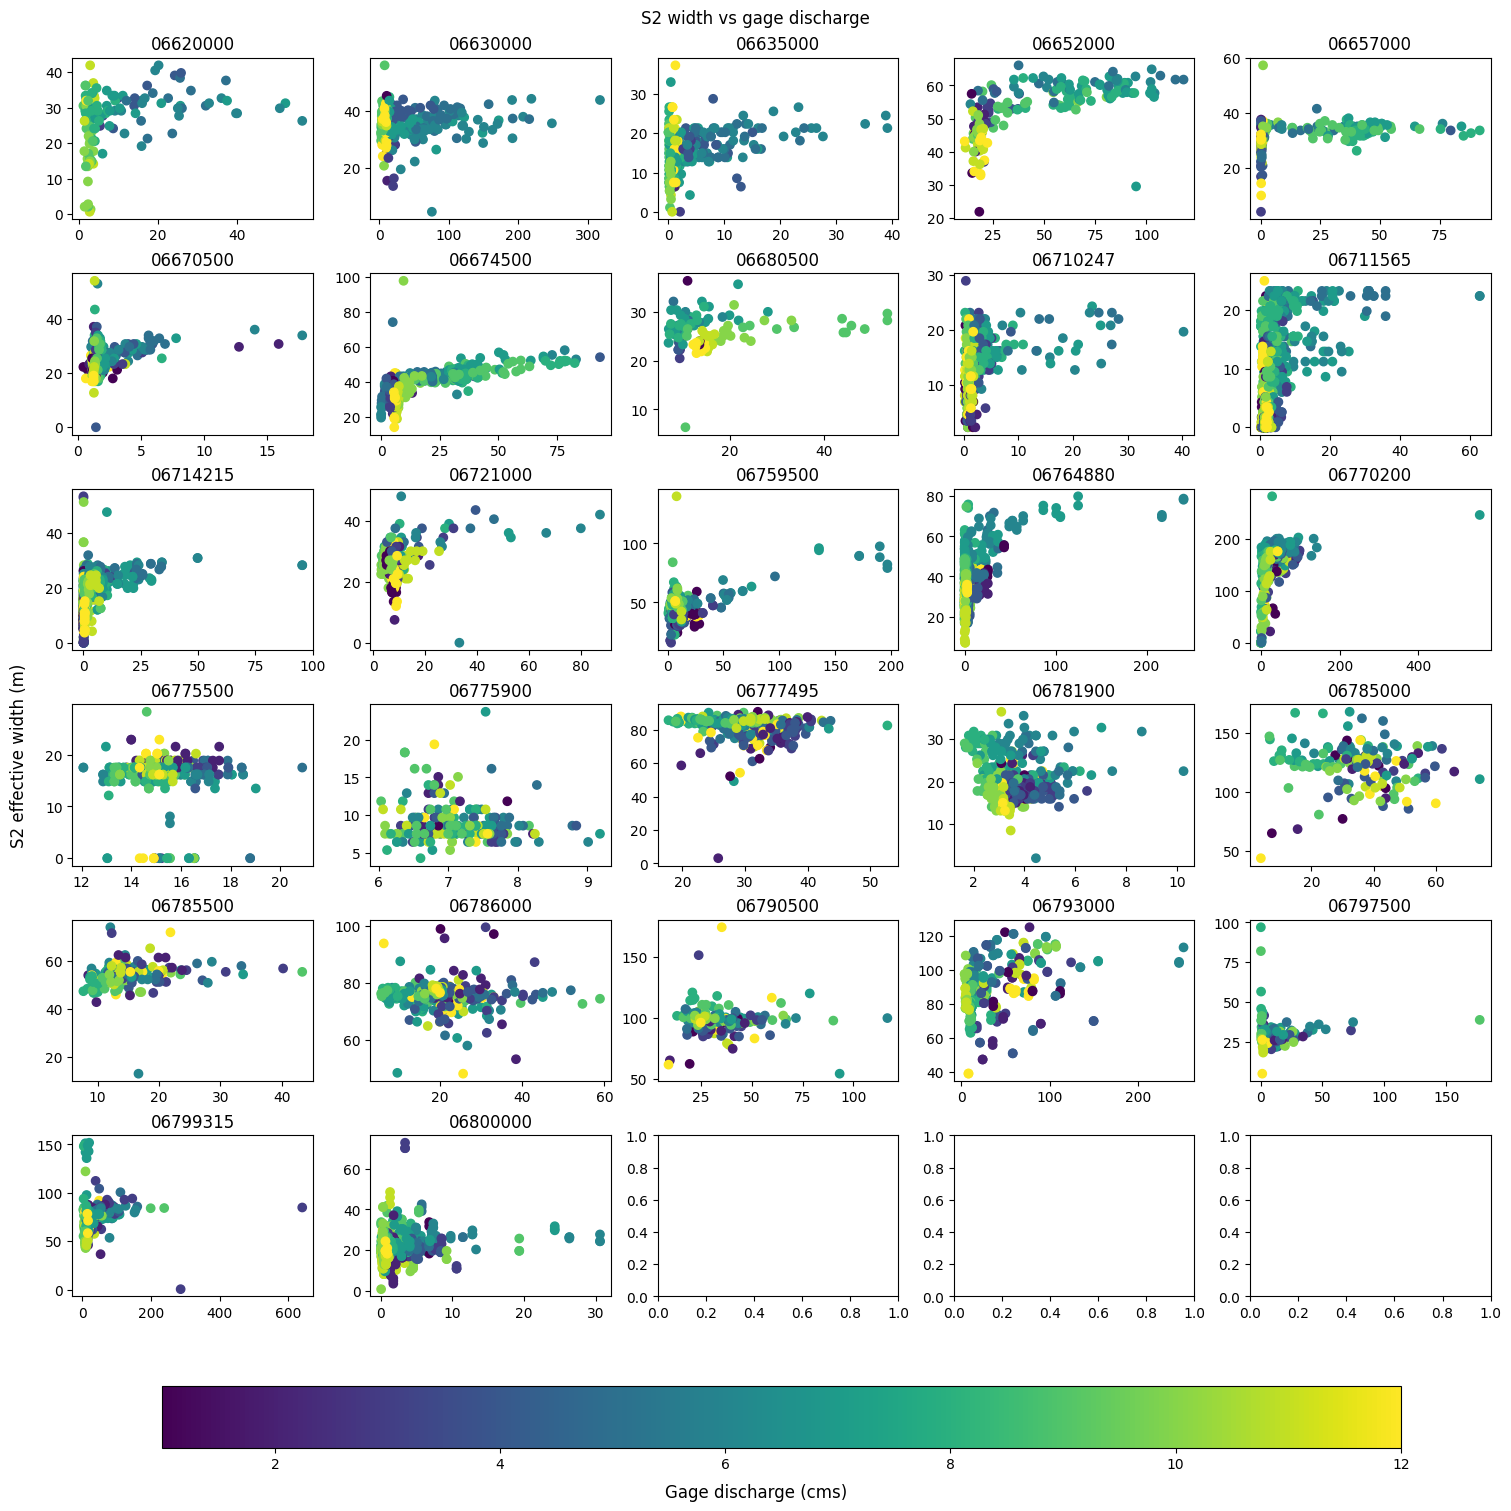

In [116]:
t = alldata.loc[alldata.fraction_cloud < 0.2]
t = t.loc[t.fraction_snow < 0.5]

t = t.reset_index()
t.date = pd.to_datetime(t.date)
t['month'] = t.date.dt.month

fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(15, 15), constrained_layout=True)
p = 0
for g, df in t.groupby('site_no'):


    ax = axs.flatten()[p]

    dat = ax.scatter(df.Q_cms, df.sat_width_m, c=df.month, vmin=1, vmax=12)

    ax.set_title(g)
    p += 1

fig.supxlabel('Gage discharge (cms)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('S2 width vs gage discharge')

fig.colorbar(dat, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)


Text(0.5, 0.98, 'S2 width vs gage discharge')

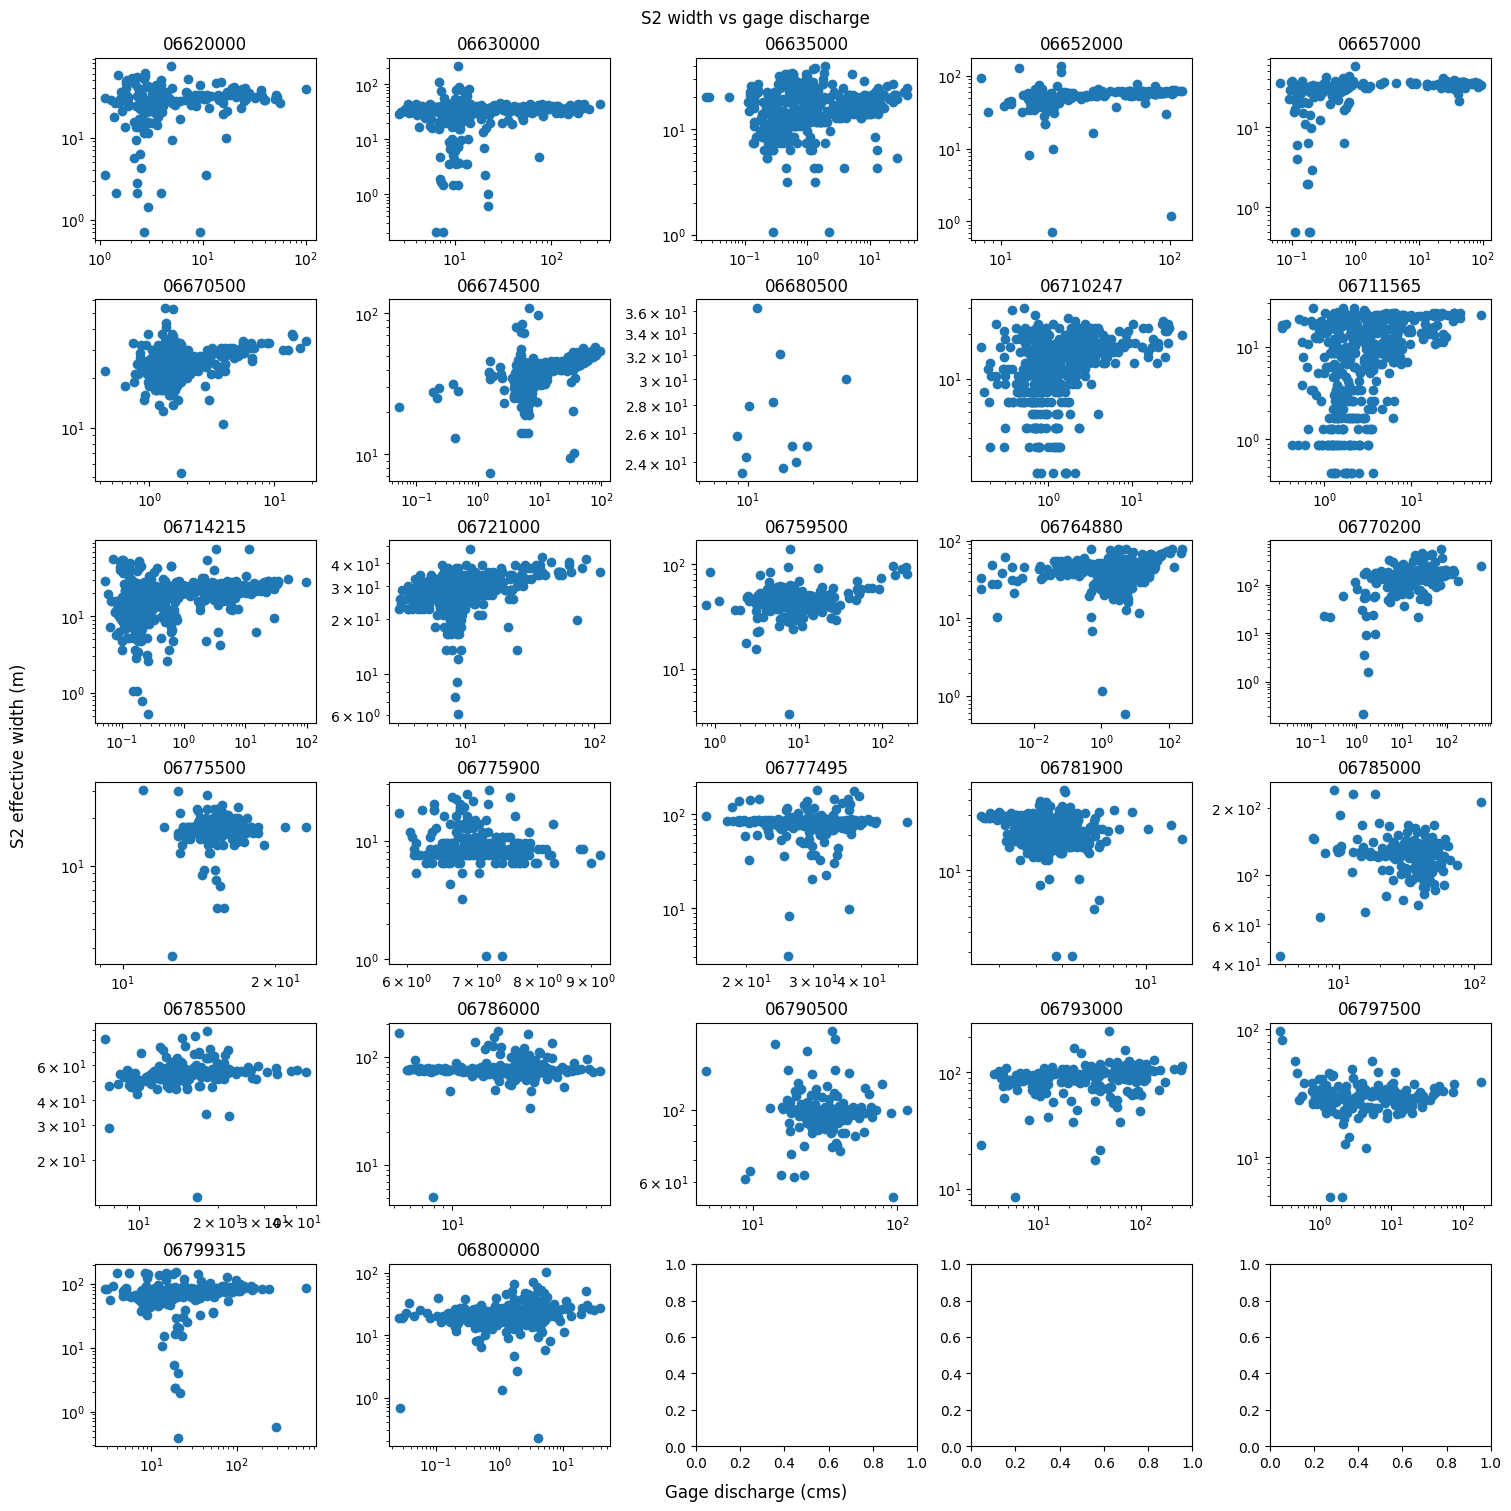

In [52]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(15, 15), constrained_layout=True)
p = 0
for g, df in alldata.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.mean_sat_width_m)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(g)
    p += 1

fig.supxlabel('Gage discharge (cms)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('S2 width vs gage discharge')